In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
#from dataset import Datasets

import copy
import random
import time
import os, argparse
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable


In [ ]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')
!pwd

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
os.makedirs("models_cnn", exist_ok=True)

opt = {
    'n_epochs' : 100, # number of epochs of training
    'batch_size' : 64, # size of the batches
    'lr' : 0.0002, # adam: learning rate
    'b1' : 0.5, # adam: decay of first order momentum of gradient
    'b2': 0.999, # adam: decay of first order momentum of gradient
    'n_cpu': 8, # number of cpu threads to use during batch generation
    'latent_dim': 100, # dimensionality of the latent space
    'img_size': 32, # size of each image dimension
    'channels': 1, # number of image channels
    'sample_interval': 400 # interval between image sampling
}
print(opt)
!ls

{'n_epochs': 100, 'batch_size': 64, 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'n_cpu': 8, 'latent_dim': 100, 'img_size': 32, 'channels': 1, 'sample_interval': 400}
'assignment cse598'
 Assignment_final_128_0001_20.ipynb
 Assignment_final_128_001_20.ipynb
 Assignment_final_64_0001_25.ipynb
 Assignment_final_64_0001_30.ipynb
 Assignment_final_64_001_20.ipynb
 Assignment_final_64_001_25.ipynb
'Copy of correct Assignment1.ipynb'
'Copy of Dataset2_AkhilKumarGudipoodi_Code_Model_Training.ipynb'
'Copy of Dataset_Generation_p7_T1.ipynb'
'Copy of FSL_Project_2.ipynb'
'Copy of GAN.ipynb'
'Copy of merge.ipynb'
'Copy of pytorch_tutorial.ipynb'
'Copy of skonda15_cse569_fsl_project.ipynb'
'Copy of train_t5_(1).ipynb'
'correct Assignment1.ipynb'
 CSE598
 CSE598Models
'Dataset2_AkhilKumarGudipoodi_Code_Model_Training (1).ipynb'
 Dataset2_AkhilKumarGudipoodi_Code_Model_Training.ipynb
 Dataset2_AkhilKumarGudipoodi_Patient_Test.csv
 Dataset2_AkhilKumarGudipoodi_Patient_Train.csv
 Dataset2_SaicharanPapani_Cod

In [ ]:
cuda = True if torch.cuda.is_available() else False

## **CNN Model and function definations**

In [ ]:
class MnistCnn(nn.Module):
    def __init__(self,):
        super(MnistCnn,self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_channels = 1,out_channels = 64, kernel_size = 5, stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64,out_channels = 64, kernel_size = 5, stride = 2),
            nn.ReLU(),
            nn.Dropout(p=0.25)

        )

        self.dense = nn.Sequential(
            nn.Linear(6400,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,10)
        )

    def forward(self,x):
        # x= input tensor 
        output = self.conv(x)
        output = output.view(output.shape[0],-1)
        output = self.dense(output)
        # output is now a tensor of shape (N,10) this is pre-softmax logits of N images
        soft = nn.Softmax(dim=1)
        output = soft(output)
        return output 

In [ ]:
total_epoch = 100
batch_size = 50 
valid_size = 10000

In [ ]:
model = MnistCnn()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
summary(model, input_size = (1,28,28), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
              ReLU-2           [-1, 64, 24, 24]               0
            Conv2d-3           [-1, 64, 10, 10]         102,464
              ReLU-4           [-1, 64, 10, 10]               0
           Dropout-5           [-1, 64, 10, 10]               0
            Linear-6                  [-1, 128]         819,328
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 924,746
Trainable params: 924,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.71
Params size (MB): 3.53
Estimated Total Size (MB): 4.24
-------------------------------------------

In [ ]:
#moving the model to GPU
model = model.to(device)

In [ ]:
model_folder = os.path.abspath('./models_cnn')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_path = os.path.join(model_folder, 'mnist_classifier.pth')

In [ ]:
transformation = transforms.Compose([
    transforms.RandomCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

root = '/content/gdrive/My Drive/Colab Notebooks/'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
val_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

val_loader = torch.utils.data.DataLoader(
                dataset=val_set,
                batch_size=batch_size,
                shuffle=False)

#mnist = datasets("mnist",transformation,batch_size,valid_size)
#trainloader,val_loader = mnist.load_train()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Colab Notebooks/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Colab Notebooks/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Colab Notebooks/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Colab Notebooks/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/MNIST/raw



In [ ]:
from IPython.display import HTML, display
import time

def progress(epoch, value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}/{max}
        </progress>
        <p>epoch: {epoch}, batch: {value}/{max}</p>
    """.format(value=value, max=max, epoch=epoch))

In [ ]:
def train(model,total_epoch,optimizer,criterion,device,model_path,train_loader,val_loader):

    # pdb.set_trace()
    train_out = display( progress(1, 0, len(train_loader)), display_id=True)
    val_out = display( progress(1, 0, len(train_loader)), display_id=True)
    
    train_loss = []
    train_acc = []

    val_loss = []
    val_acc = []

    best_acc = 0.0

    for epoch in range(total_epoch):

        model.train()  # Set model to training mode it is imp as we are also evaluating in each epoch using validation set
        
        running_loss = 0.0
        running_corrects = 0.0
        epoch_size = 0.0
        val_out.update(progress(epoch+1, 0, len(val_loader)))
        for batch_idx, (inputs, labels) in enumerate(trainloader):

            #moving each input,label batch tensor to gpu

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            _, preds = torch.max(outputs, 1)

            optimizer.step()

            # print statistics
            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            
            epoch_size += inputs.size(0)
            #print(inputs.size(0), len(trainloader), loss, loss.item(), len(preds), torch.sum(preds == labels.data))
            train_out.update(progress(epoch+1, batch_idx, len(trainloader)))
            
        # Normalizing the loss by the total number of train batches
        
        running_loss /= epoch_size
        running_corrects =  running_corrects.double() / epoch_size
        
        train_loss.append(running_loss)
        train_acc.append(running_corrects)
        
        print('train Loss: {:.4f} Acc: {:.4f}%'.format(running_loss, running_corrects*100))
        
        # evalute
        print('Finished epoch {}, starting evaluation'.format(epoch+1))

        model.eval()   # Set model to evaluate mode
        
        running_loss = 0.0
        running_corrects = 0.0
        epoch_size = 0.0
        
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
                epoch_size += inputs.size(0)
                val_out.update(progress(epoch+1, batch_idx, len(val_loader)))
        
        running_loss /= epoch_size
        running_corrects =  running_corrects.double() / epoch_size
        
        print('Validation Loss: {:.4f} Acc: {:.4f}%'.format(running_loss, running_corrects*100))
        
        val_loss.append(running_loss)
        val_acc.append(running_corrects)
        
        # deep copy the model
        if running_corrects > best_acc:
            print("saving best model val_acc : {:.4f}".format(running_corrects))
            best_acc = running_corrects
            
            model_copy = copy.deepcopy(model)
            #moving the deep copy of the model to cpu as it will take space on gpu, also it is important to not move the original model as it is still training on GPU
            model_copy = model_copy.cpu()
            
            model_state_dict = model_copy.state_dict()
            torch.save(model_state_dict, model_path)

            del model_copy

    print('==> Finished Training ...')
        #     print("saving best model val_acc : {:.4f}".format(running_corrects))  

    torch.save(model.state_dict(), model_path)
    return (train_loss, train_acc, val_loss, val_acc)


In [ ]:
transformation = transforms.Compose([
    transforms.RandomCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

## **Data Loading**

In [ ]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
transform = transforms.Compose([
    transforms.RandomCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])
train_data = datasets.MNIST('.', download=True, train=True, transform=transform)
# FASHION_train = Subset(FASHION_trainval, range(50000))
# FASHION_val = Subset(FASHION_trainval, range(50000,60000))
test_data = datasets.MNIST('.', download=True, train=False, transform=transform)
print("Done!")


Loading datasets...
Done!


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 54000
Number of validation examples: 6000


In [ ]:
# Create dataloaders
# TODO: Experiment with different batch sizes
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# **Training**

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(model,total_epoch,optimizer,criterion,device,model_path,trainloader,val_loader)

train Loss: 0.0444 Acc: 23.7833%
Finished epoch 1, starting evaluation
Validation Loss: 0.0371 Acc: 68.8500%
saving best model val_acc : 0.6885
train Loss: 0.0355 Acc: 70.7463%
Finished epoch 2, starting evaluation
Validation Loss: 0.0338 Acc: 78.1500%
saving best model val_acc : 0.7815
train Loss: 0.0342 Acc: 76.1130%
Finished epoch 3, starting evaluation
Validation Loss: 0.0335 Acc: 79.2500%
saving best model val_acc : 0.7925
train Loss: 0.0338 Acc: 77.8630%
Finished epoch 4, starting evaluation
Validation Loss: 0.0332 Acc: 80.7333%
saving best model val_acc : 0.8073
train Loss: 0.0335 Acc: 79.1981%
Finished epoch 5, starting evaluation
Validation Loss: 0.0330 Acc: 81.6333%
saving best model val_acc : 0.8163
train Loss: 0.0333 Acc: 80.2704%
Finished epoch 6, starting evaluation
Validation Loss: 0.0329 Acc: 81.9500%
saving best model val_acc : 0.8195
train Loss: 0.0331 Acc: 81.0667%
Finished epoch 7, starting evaluation
Validation Loss: 0.0327 Acc: 82.7000%
saving best model val_acc :

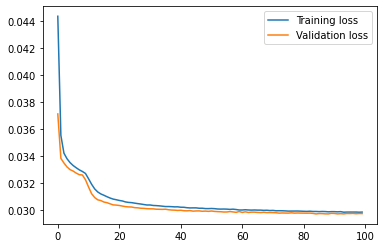

In [ ]:
line1, = plt.plot(train_loss, label='Training loss')
line2, = plt.plot(val_loss, label='Validation loss')
plt.legend(handles=[line1, line2])
plt.show()

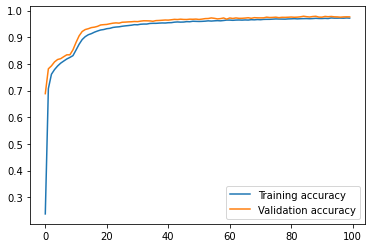

In [ ]:
train_x = list(map(lambda x : x.item(), train_acc))

val_x = list(map(lambda x : x.item(), val_acc))

line3, = plt.plot(train_x, label='Training accuracy')
line4, = plt.plot(val_x, label='Validation accuracy')
plt.legend(handles=[line3, line4])



## **Testing the model**

In [ ]:
def clean_test(model,testloader,device):

    model.eval()
    running_corrects = 0.0
    epoch_size = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
            
            epoch_size += inputs.size(0)

    running_corrects =  running_corrects.double() / epoch_size

    print('Test  Acc: {:.4f}%'.format(running_corrects*100))

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
clean_test(model,test_loader,device)

Test  Acc: 98.0800%


## **Adversarial Images Creations**

In [ ]:
batch_size = 50
valid_size = 10000

In [ ]:
!pip install foolbox
import foolbox as fb #python library to produce adversarial examples
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.3 MB/s eta 0:00:00


In [ ]:
def fgsm_adv_generate(dataset_name,adv_root_folder,model,device,test_loader):


    model.eval()

    root_path_to_store = adv_root_folder + dataset_name 

    if not os.path.exists(root_path_to_store):
      os.mkdir(root_path_to_store)
    
    fmodel = fb.PyTorchModel(model, bounds=(-1,1),device = device)
    attack = fb.attacks.FGSM()

    fgsm_adv = []
    fgsm_index = []
    fgsm_label = []
    sum = 0

    #for index
    count = 0
    for imgs_batch,labels_batch in test_loader:
      imgs_batch = imgs_batch.to(device)
      labels_batch = labels_batch.to(device)
      raw, clipped, is_adv = attack(fmodel, imgs_batch, labels_batch, epsilons=0.3)
      sum = sum + torch.sum(is_adv)
      for i in range(50):
        fgsm_adv.append(clipped[i])
        fgsm_label.append(labels_batch[i])
        fgsm_index.append(count+i)

      count = count + i + 1
    
    with open (root_path_to_store+'/FGSM_indexs.pickle', 'wb') as fp:
        pickle.dump(fgsm_index, fp)

    with open (root_path_to_store+'/FGSM_adv_images.pickle', 'wb') as fp:
        pickle.dump(fgsm_adv, fp)
        
    with open (root_path_to_store+'/FGSM_adv_label.pickle', 'wb') as fp:
        pickle.dump(fgsm_label, fp)

    print("model accuracy on adversarial examples : ", 1 - (sum/len(fgsm_adv)))

In [ ]:
adv_root_folder = "./adv/"
if not os.path.exists(adv_root_folder):
    os.mkdir(adv_root_folder)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_path = "/content/gdrive/My Drive/Colab Notebooks/CSE598/models_cnn/mnist_classifier.pth"

model = MnistCnn()
model.load_state_dict(torch.load(model_path,map_location = torch.device("cpu"))) # if no gpu else simple torch.load(model_path)
model.to(device)

MnistCnn(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=6400, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
dataset_name = "mnist"
fgsm_adv_generate(dataset_name,adv_root_folder,model,device,test_loader)

model accuracy on adversarial examples :  tensor(0.6081, device='cuda:0')
